In [36]:
# load package
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation  import train_test_split
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import cross_validation

# set path
import os
default_path = "/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic/"
os.chdir(default_path)

# skip interaction warning
import warnings; 
warnings.filterwarnings('ignore')

In [37]:
# Data Prepararion
# read data
train=pd.read_csv('train.csv',encoding='big5')
test=pd.read_csv('test.csv',encoding='big5')
submit=pd.read_csv('gender_submission.csv',encoding='big5')

In [38]:
# append in ONE data
data=train.append(test, ignore_index=True)

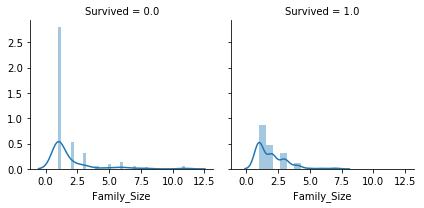

In [39]:
data['Family_Size']=data['Parch']+data['SibSp']+1
g=sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Family_Size',kde=True)#kde是否要折線圖的參數

In [40]:
#設法整理出「尊稱」這個因子
data['Title1']=data['Name'].str.split('.',expand=True)[0]
#expand=True是讓資料在dataframe展開欄位
#1是選第二項的title
data['Title1'].head(10)
# 切出尊稱
data['Title1']=data['Title1'].str.split(', ',expand=True)[1].str.strip()#[1]代表切出第2個'dlm'前面到第一個的字串
data['Title1'].head(10)
# 秀出dintinct後的title1
data['Title1'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [41]:
#合併成比較常出現的姓氏在Title2
data['Title2']=''
for idx, row in data.iterrows():  # 請務必記得加上idx，不然跑回圈的item會變成(idx, row)
    Sex = row['Sex']
    Title1=row['Title1']
    if Title1=='Master':
        Title2='Master'
    elif Title1=='Mrs':
        Title2='Mrs'
    elif Title1=='Miss':
        Title2='Miss'
    elif Sex=='male':
        Title2='Mr'
    else:
        Title2='Miss'
    data.loc[idx,'Title2']=Title2 #???
data['Title2'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [42]:
# 票的前幾碼代號可能有意義，流水編沒有所以拿掉
data['Ticket_info'] = data['Ticket'].apply(lambda x : x.replace(".","").replace("/","").strip().split(' ')[0] if not x.isdigit() else 'X')
data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [43]:
tt = data.groupby(by='Ticket_info', as_index=False).agg({'PassengerId': pd.Series.nunique})

In [44]:
tt['PassengerId'].describe()

count     37.000000
mean      35.378378
std      156.804434
min        1.000000
25%        1.000000
50%        4.000000
75%        9.000000
max      957.000000
Name: PassengerId, dtype: float64

In [45]:
#把count distinct的ticket_info低於第一四分位數的都改成None
tt['Ticket_info_rev']=tt['Ticket_info']
tt.Ticket_info_rev[tt.PassengerId<14]='None' #STONO是14
tt

,Ticket_info,PassengerId,Ticket_info_rev
0,A,1,None
1,A4,10,None
2,A5,28,A5
3,AQ3,1,None
4,AQ4,1,None
5,AS,1,None
6,C,8,None
7,CA,68,CA
8,CASOTON,1,None
9,FC,3,None


In [46]:
#leftjoin Ticket_info_rev到大表
tt=tt.drop(['PassengerId'], axis=1)
data=pd.merge(left=data, right=tt,how='left', on=['Ticket_info', 'Ticket_info'])
data.head(4)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info,Ticket_info_rev
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,Mr,Mr,A5,A5
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Mrs,Mrs,PC,PC
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,Miss,Miss,STONO2,None
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Mrs,Mrs,X,X


In [47]:
# 抓船艙第一碼英文
# 送出kaggle成績沒有比較好，一堆空的也是合理
data['Cabin_info']=data['Cabin'].str[:1]
data['Cabin_info']=data['Cabin_info'].fillna('N')#空的補N
data['Cabin_info'].unique()

array(['N', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [48]:
'''
data['Cabin_info2']=data['Cabin_info']
data.Cabin_info2[data.Cabin_info in ('N','C')]='mm'
data.head()'''

"\ndata['Cabin_info2']=data['Cabin_info']\ndata.Cabin_info2[data.Cabin_info in ('N','C')]='mm'\ndata.head()"

In [49]:
#整併人數太少的cabin
#把'F','G','T'變成'Merged'
data['Cabin_info'].replace(['F','G','T'],'Merged',inplace=True)#inplace如果是false就是改爽的不會更動到值

In [50]:
#
print('Embarked原遺漏的人數：',data['Embarked'].isnull().sum())
#最多在S港上傳，填補遺漏值
data['Embarked']=data['Embarked'].fillna('S')

Embarked原遺漏的人數： 2


In [51]:
#
print('Fare原遺漏的人數：',data['Fare'].isnull().sum())
#用平均填補遺漏值
data['Fare']=data['Fare'].fillna(data['Fare'].mean())

Fare原遺漏的人數： 1


In [52]:
#
#print('Age遺漏的人數：',data['Age'].isnull().sum())
#用中位數填補遺漏值
#data['Age']=data['Age'].fillna(data['Age'].median())

In [53]:
#用(找是否有別名
data['NickName_ind']= data['Name'].str.contains('\(',na=False)*1
data['Quotation_ind']= data['Name'].str.contains('\"',na=False)*1
qta = data.groupby(by='Quotation_ind', as_index=False).agg({'PassengerId': pd.Series.nunique})
qta.head()

,Quotation_ind,PassengerId
0,0,1234
1,1,75


In [54]:
deplicate_ticket = []
for tk in data.Ticket.unique():
    tem = data.loc[data.Ticket == tk, 'Fare']
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        deplicate_ticket.append(data.loc[data.Ticket == tk,['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Family_Size', 'Title1',
       'Title2', 'Ticket_info', 'Ticket_info_rev', 'Cabin_info',
       'NickName_ind', 'Quotation_ind']])
deplicate_ticket = pd.concat(deplicate_ticket)
df_fri = deplicate_ticket.loc[(deplicate_ticket.Family_Size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.Family_Size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(df_fri,df_fami)
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print('friends: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_Size == 1]))
print('families: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_Size > 1]))
# the same ticket family or friends
data['Connected_Survival'] = 0.5 # default 
for _, df_grp in data.groupby('Ticket'):
    if (len(df_grp) > 1):
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                data.loc[data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(data[data['Connected_Survival']!=0.5].shape[0]))
data.groupby('Connected_Survival')[['Survived']].mean().round(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info,Ticket_info_rev,Cabin_info,NickName_ind,Quotation_ind
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,1,Mr,Mr,X,X,E,0,0
20,35.0,NaN,S,26.0000,"Fynney, Mr. Joseph J",0,21,2,male,0,0.0,239865,1,Mr,Mr,X,X,N,0,0
791,16.0,NaN,S,26.0000,"Gaskell, Mr. Alfred",0,792,2,male,0,0.0,239865,1,Mr,Mr,X,X,N,0,0
195,58.0,B80,C,146.5208,"Lurette, Miss. Elise",0,196,1,female,0,1.0,PC 17569,1,Miss,Miss,PC,PC,B,0,0
681,27.0,D49,C,76.7292,"Hassab, Mr. Hammad",0,682,1,male,0,1.0,PC 17572,1,Mr,Mr,PC,PC,D,0,0
61,38.0,B28,S,80.0000,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,1,Miss,Miss,X,X,B,0,0
829,62.0,B28,S,80.0000,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,1,Mrs,Mrs,X,X,B,1,0


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info,Ticket_info_rev,Cabin_info,NickName_ind,Quotation_ind
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Mrs,Mrs,PC,PC,C,1,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Mrs,Mrs,X,X,C,1,0
137,37.0,C123,S,53.1000,"Futrelle, Mr. Jacques Heath",0,138,1,male,1,0.0,113803,2,Mr,Mr,X,X,C,0,0
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,5,Master,Master,X,X,N,0,0
24,8.0,NaN,S,21.0750,"Palsson, Miss. Torborg Danira",1,25,3,female,3,0.0,349909,5,Miss,Miss,X,X,N,0,0
374,3.0,NaN,S,21.0750,"Palsson, Miss. Stina Viola",1,375,3,female,3,0.0,349909,5,Miss,Miss,X,X,N,0,0
567,29.0,NaN,S,21.0750,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",4,568,3,female,0,0.0,349909,5,Mrs,Mrs,X,X,N,1,0


people keep the same ticket: 596 
friends: 127 
families: 469 
people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [55]:
#留下準備get_dummies的欄位
for_dummy_data=data.drop(['Name','Cabin','Ticket','Ticket_info','Title1'], axis=1)
for_dummy_data.head(3)

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Family_Size,Title2,Ticket_info_rev,Cabin_info,NickName_ind,Quotation_ind,Connected_Survival
0,22.0,S,7.2500,0,1,3,male,1,0.0,2,Mr,A5,N,0,0,0.5
1,38.0,C,71.2833,0,2,1,female,1,1.0,2,Mrs,PC,C,1,0,0.5
2,26.0,S,7.9250,0,3,3,female,0,1.0,1,Miss,None,N,0,0,0.5


In [56]:
data_dummies = pd.get_dummies(for_dummy_data)
#columns可以指定哪些欄位要get_dummies
data_dummies.head(3)
#data= pd.merge(left=data, right=data_dummies, how='left', left_on='PassengerId', right_on='PassengerId',)
#data.head(4)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,Family_Size,NickName_ind,Quotation_ind,...,Ticket_info_rev_STONO,Ticket_info_rev_WC,Ticket_info_rev_X,Cabin_info_A,Cabin_info_B,Cabin_info_C,Cabin_info_D,Cabin_info_E,Cabin_info_Merged,Cabin_info_N
0,22.0,7.2500,0,1,3,1,0.0,2,0,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,2,1,1,1.0,2,1,0,...,0,0,0,0,0,1,0,0,0,0
2,26.0,7.9250,0,3,3,0,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [57]:
# 運用'Survived'欄位來判斷訓練集還是測試集
dataTrain = data_dummies[pd.notnull(data_dummies['Survived'])].sort_values(by=["PassengerId"])
dataTest = data_dummies[~pd.notnull(data_dummies['Survived'])].sort_values(by=["PassengerId"])
dataTrain.columns

Index(['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'SibSp', 'Survived',
       'Family_Size', 'NickName_ind', 'Quotation_ind', 'Connected_Survival',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male',
       'Title2_Master', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',
       'Ticket_info_rev_A5', 'Ticket_info_rev_CA', 'Ticket_info_rev_None',
       'Ticket_info_rev_PC', 'Ticket_info_rev_SCPARIS',
       'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_STONO',
       'Ticket_info_rev_WC', 'Ticket_info_rev_X', 'Cabin_info_A',
       'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_E',
       'Cabin_info_Merged', 'Cabin_info_N'],
      dtype='object')

In [95]:
dataTrain = dataTrain[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Survived',
       'Family_Size', 'NickName_ind', 'Quotation_ind', 'Connected_Survival',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male',
       'Title2_Master', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',
       #'Ticket_info_rev_A/5', 'Ticket_info_rev_CA', 
       #'Ticket_info_rev_PC', 'Ticket_info_rev_SC/PARIS',
       #'Ticket_info_rev_SOTON/OQ', 'Ticket_info_rev_W/C',
       'Ticket_info_rev_X','Ticket_info_rev_None',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_E', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]
#把上面dataTrain.columns的結果貼到dataTest，再去掉'Survived'
dataTest = dataTest[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp',
       'Family_Size', 'NickName_ind', 'Quotation_ind', 'Connected_Survival',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male',
       'Title2_Master', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',
       #'Ticket_info_rev_A/5', 'Ticket_info_rev_CA', 
       #'Ticket_info_rev_PC', 'Ticket_info_rev_SC/PARIS',
       #'Ticket_info_rev_SOTON/OQ', 'Ticket_info_rev_W/C',
       'Ticket_info_rev_X','Ticket_info_rev_None',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_E', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]
#X_feature = dataTrain.drop('Class',1)
X_feature = dataTrain[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp',
       'Family_Size', 'NickName_ind', 'Quotation_ind', 'Connected_Survival',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male',
       'Title2_Master', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',
       #'Ticket_info_rev_A/5', 'Ticket_info_rev_CA', 
       #'Ticket_info_rev_PC', 'Ticket_info_rev_SC/PARIS',
       #'Ticket_info_rev_SOTON/OQ', 'Ticket_info_rev_W/C',
       'Ticket_info_rev_X','Ticket_info_rev_None',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_E', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]
y_t =dataTrain['Survived']

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_t, test_size=0.3, random_state=7)

In [97]:
# Function for Measure Performance
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

In [98]:
# use LabelEncoder to convert categorical features to int type before construct Dataset
from sklearn.preprocessing import LabelEncoder
def label_encoder(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """
    # Label encode categoricals
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
    return input_df, categorical_feats.tolist(), encoder_dict
dataTrain, categorical_feats, encoder_dict = label_encoder(dataTrain)
X = dataTrain.drop('Survived', axis=1)
y = dataTrain.Survived

# Prepare dataset 
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=seed)

In [113]:
# Grid Search
print('Start training...')
estimator = lgb.LGBMClassifier(objective = 'binary', n_estimators = 200, random_state=0)

param_grid = {
    'learning_rate': [0.08],#[0.03,0.05,0.07] then 0.03 [0.02,0.03,0.04] then 0.04 [0.03,0.04,0.05] then 0.04 np.arange(0.01,0.09,0.01)
    'num_leaves': [10],
    #[30,40,50] then 30 [20,25,30] then 20 [17,20,23] then 17 [15,17,19] then 15 [14,15,16] then 14
    #[13,14,15] then 13 [11,12,13] then 11 [7,8,9,10,11] then 7 [5,6,7] then 5
    'feature_fraction': [0.7],#[0.4,0.6,0.8] then 0.4 [0.3,0.4,0.5] then 0.4 np.arange(0.1,0.9,0.1)
    'bagging_fraction': [0.01],#[0.6,0.7,0.8], then 0.6 [0.4,0.5,0.6] then 0.4 [0.3,0.4,0.5] then 0.3
    #[0.2,0.3,0.4] then 0.2 [0.1,0.2,0.3] then 0.1 [0.05,0.1,0.2] then 0.05 [0.025,0.05,0.1] then 0.025
    #[0.0125,0.025,0.05] then 0.0125 np.arange(0.01,0.09,0.01)
    'max_depth':np.arange(5,19,2),#[4,6,8] then 6 [5,6] then 5 [4,5] then 4
    'max_bin':np.arange(5,19,2), #[10,15,20] then 15 [13,15,17] then 15 [14,15,16] then 15
    'lambda_l1': [0.6],#[0.1,0.2,0.3] then 0.3 [0.3,0.4,0.5] then 0.5 [0.5,0.6,0.7] then 0.5 [0.4,0.5,0.6] then 0.5
    #np.arange(0.1,0.9,0.1)
    'lambda_l2': [0.04], #[0.08,0.09,0.1] then 0.08 [0.06,0.07,0.08] then 0.06 [0.04,0.05,0.06] then 0.05
    #np.arange(0.01,0.09,0.01)
    'min_split_gain':[0.06],#[0.05,0.06,0.07]then 0.07 [0.05,0.06,0.07] then 0.06 [0.03,0.04,0.05] then 0.03
    'min_child_weight':[8] #[3,5,7] then 5 [4,5,6] then 5 [4,5,6] then 4 [3,4,5] then 4 np.arange(1,9,1)
}

LGBM_grid = GridSearchCV(estimator, param_grid)
LGBM_grid.fit(X_train, y_train)
print('Best parameters found by grid search are:', LGBM_grid.best_params_)

# Final Model
evals_result = {} 
print('Start predicting...')
LGBM_grid_final = lgb.LGBMClassifier(objective = 'binary',
                                      #learning_rate = 0.05, 
                                     learning_rate = LGBM_grid.best_params_['learning_rate'],
                                     n_estimators = 100, 
                                     random_state=0,
                              num_leaves = LGBM_grid.best_params_['num_leaves'],
                                feature_fraction = LGBM_grid.best_params_['feature_fraction'], 
                              bagging_fraction = LGBM_grid.best_params_['bagging_fraction'],
                             max_depth = LGBM_grid.best_params_['max_depth'],
                              max_bin = LGBM_grid.best_params_['max_bin'],
                              lambda_l1 = LGBM_grid.best_params_['lambda_l1'],
                              lambda_l2 = LGBM_grid.best_params_['lambda_l2'],
                            min_split_gain = LGBM_grid.best_params_['min_split_gain'],
                            min_child_weight = LGBM_grid.best_params_['min_child_weight'])
LGBM_grid_final_fit = LGBM_grid_final.fit(X_train, y_train)
print('Predicting is over')

Start training...
Best parameters found by grid search are: {'bagging_fraction': 0.01, 'feature_fraction': 0.7, 'lambda_l1': 0.6, 'lambda_l2': 0.04, 'learning_rate': 0.08, 'max_bin': 7, 'max_depth': 5, 'min_child_weight': 8, 'min_split_gain': 0.06, 'num_leaves': 10}
Start predicting...
Predicting is over


Accuracy:0.810
Classification report
             precision    recall  f1-score   support

        0.0       0.79      0.91      0.85       156
        1.0       0.84      0.67      0.75       112

avg / total       0.81      0.81      0.81       268

Confusion matrix
[[142  14]
 [ 37  75]]
ROC AUC Score
0.8629807692307692
Feature importances: [126, 50, 4, 54, 10, 3, 14, 0, 68, 25, 0, 11, 12, 3, 0, 0, 47, 0, 1, 0, 0, 33]
Plot feature importances...


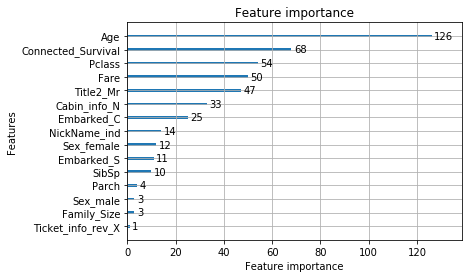

In [114]:
#對test算
LGBM_grid_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_grid_final, show_classification_report=True, show_confusion_matrix=True)

# feature importances
print('Feature importances:', list(LGBM_grid_final.feature_importances_))

# visualization
print('Plot feature importances...')
ax = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=30)
plt.show()

In [115]:
#predict Test data
#submit the data to kaggle
LGBM_grid_final_fit_res =LGBM_grid_final_fit.predict(dataTest)
submit['Survived'] = LGBM_grid_final_fit_res
#submit['Survived'] = GBDT_res
submit['Survived'] = submit['Survived'].astype(int)

In [116]:
submit.to_csv('submit_to_kaggle.csv', index= False)
%pwd

'/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic'

In [106]:
print("一樣的x去做")
#print('\n')
print("CART:"+"Your submission scored 0.74641")
print("RF:"+"Your submission scored 0.76076")
print("GBDT:"+"Your submission scored 0.77511")
print("RF(18個X):"+"Your submission scored 0.79425")
print("lightGBM(用綽號、年紀遺漏不處理):"+"Your submission scored 0.79904")
print("lightGBM(用綽號、年紀遺漏不處理、加Connected_Survival Quotation_ind):"+"Your submission scored 0.80861")
print("lightGBM(同上，調參數):"+"Your submission scored 0.81339")

一樣的x去做
CART:Your submission scored 0.74641
RF:Your submission scored 0.76076
GBDT:Your submission scored 0.77511
RF(18個X):Your submission scored 0.79425
lightGBM(用綽號、年紀遺漏不處理):Your submission scored 0.79904
lightGBM(用綽號、年紀遺漏不處理、加Connected_Survival Quotation_ind):Your submission scored 0.80861
lightGBM(同上，調參數):Your submission scored 0.81339


In [68]:
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

KeyboardInterrupt: 

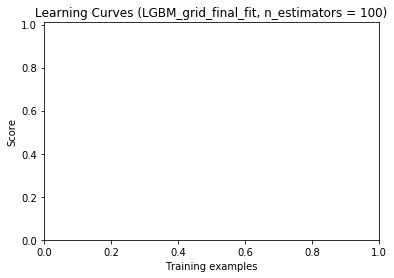

In [70]:
import matplotlib.pyplot as plt
title = "Learning Curves (LGBM_grid_final_fit, n_estimators = 100)"
cv = cross_validation.ShuffleSplit(dataTrain.drop('Survived',1).shape[0], n_iter=10,test_size=0.3, random_state=0)
plot_learning_curve(LGBM_grid_final_fit, title, X_feature,y_t, (0.0, 1.01), cv=cv, n_jobs=4)
plt.show()